In [32]:
from google.colab import drive
drive.mount('/content/drive')

#check inside Directory

import os
os.listdir('/content/drive/MyDrive/Project')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Copy of Copy of Lab - Convolutional Neural Networks_v2.ipynb',
 'Train',
 'Test',
 ' Drone_RestNet.ipynb',
 'code Drone_CNN.ipynb']

In [33]:
import pandas as pd
import numpy as np
import tensorflow as tf
%config Completer.use_jedi = False

print(tf.test.gpu_device_name())

In [34]:

# Create Dataset using TensorFlow
train_dir = '/content/drive/MyDrive/Project/Train'
test_dir = '/content/drive/MyDrive/Project/Test'
batch_size = 32
img_height = 100
img_width = 100


In [35]:

# Create the training set
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, subset='training', validation_split=0.2, seed=0,
    shuffle=True,
    image_size=(img_height,img_width),
    batch_size=batch_size)


Found 1131 files belonging to 2 classes.
Using 905 files for training.


In [36]:

# Create the validation set
vald_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, subset='validation', validation_split=0.2, seed=0,
    shuffle=True,
    image_size=(img_height,img_width),
    batch_size=batch_size)


Found 1131 files belonging to 2 classes.
Using 226 files for validation.


In [37]:

# Create the test set
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, seed=0,
    shuffle=True,
    image_size=(img_height,img_width),
    batch_size=batch_size)

class_names = test_data.class_names
print(class_names)



Found 494 files belonging to 2 classes.
['Drone', 'Non-Drone']


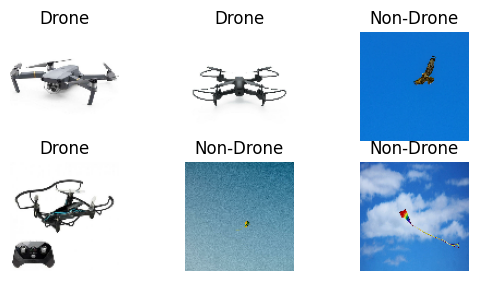

In [38]:
# Visualize some images from the test set
import matplotlib.pyplot as plt
for images, labels in test_data.take(1):
    for i in range(6):  # Display only six images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()



In [39]:
# ---- Binary Classification Using ResNet50 ----

from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Load the pre-trained ResNet50 model without the top (classification) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model to prevent retraining its weights
base_model.trainable = False

# Add custom layers for binary classification
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Global pooling to reduce dimensions
    layers.Dense(256, activation='relu'),  # Fully connected layer
    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid for binary classification
])

# Model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [40]:

# Compile the model with binary cross-entropy loss
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use binary cross-entropy loss for binary classification
              metrics=['accuracy'])



In [30]:
# ---- Model Training ----

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
filepath = 'checkpoints/resnet50_binary_classification.weights.h5'
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss'),
    ModelCheckpoint(filepath=filepath, monitor='val_loss', save_weights_only=True)
]

# Train the model
history = model.fit(train_data, validation_data=vald_data, epochs=50, callbacks=callbacks)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.7262 - loss: 1.1539 - val_accuracy: 0.9513 - val_loss: 0.1430
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9490 - loss: 0.1265 - val_accuracy: 0.9513 - val_loss: 0.1348
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.9766 - loss: 0.0723 - val_accuracy: 0.9513 - val_loss: 0.1410
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.9903 - loss: 0.0440 - val_accuracy: 0.9646 - val_loss: 0.1106
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.9956 - loss: 0.0248 - val_accuracy: 0.9558 - val_loss: 0.0999
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.9996 - loss: 0.0147 - val_accuracy: 0.9558 - val_loss: 0.1059
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9977 - loss: 0.0127 - val_accuracy: 0.9602 - val_loss: 0.1025
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.9991 - loss: 0.0080 - val_accuracy: 0.9558 - val_loss:

In [31]:
# ---- Model Training ----

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
filepath = 'checkpoints/resnet50_binary_classification.weights.h5'  # Changed filepath to end with .weights.h5
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss'),
    ModelCheckpoint(filepath=filepath, monitor='val_loss', save_weights_only=True)
]

# Train the model
history = model.fit(train_data, validation_data=vald_data, epochs=50, callbacks=callbacks)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9646 - val_loss: 0.1007
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.9602 - val_loss: 0.1028
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9602 - val_loss: 0.1028
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.9602 - val_loss: 0.1041
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9602 - val_loss: 0.1050
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9646 - val_loss: 0.1067


In [41]:
# Define callbacks
filepath = 'checkpoints/resnet50_binary_classification.weights.h5' # Change filepath to end with .weights.h5
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss'),
    ModelCheckpoint(filepath=filepath, monitor='val_loss', save_weights_only=True)
]

# Train the model
history = model.fit(train_data, validation_data=vald_data, epochs=50, callbacks=callbacks)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.7442 - loss: 0.8226 - val_accuracy: 0.9381 - val_loss: 0.1607
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.9436 - loss: 0.1253 - val_accuracy: 0.9381 - val_loss: 0.1434
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9783 - loss: 0.0674 - val_accuracy: 0.9469 - val_loss: 0.1363
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9899 - loss: 0.0447 - val_accuracy: 0.9558 - val_loss: 0.1217
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9958 - loss: 0.0257 - val_accuracy: 0.9513 - val_loss: 0.1070
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.9996 - loss: 0.0155 - val_accuracy: 0.9558 - val_loss: 0.1104
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9977 - loss: 0.0114 - val_accuracy: 0.9558 - val_loss: 0.1117
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.9991 - loss: 0.0074 - val_accuracy: 0.9513 - val_loss:

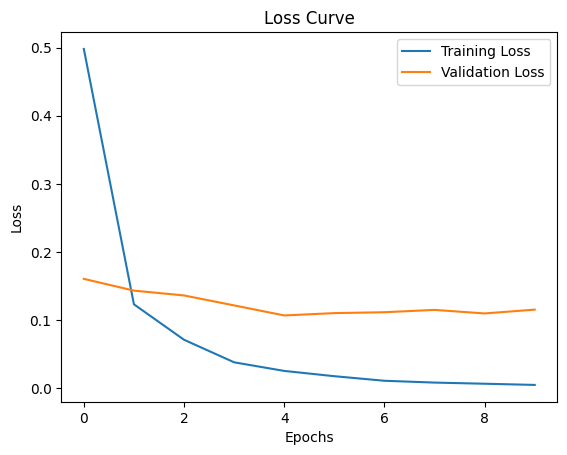

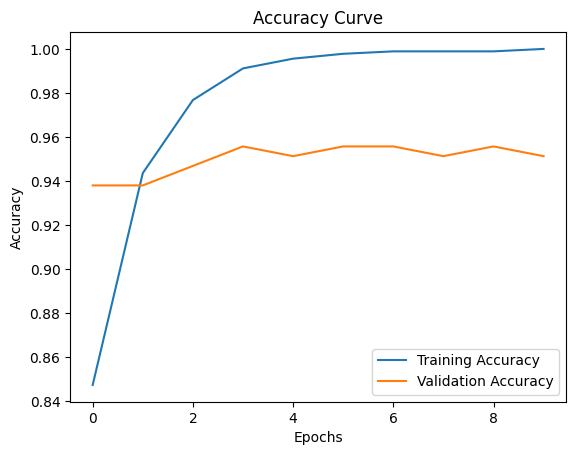

In [42]:

# ---- Plot Training and Validation Metrics ----

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()



In [43]:
# ---- Load Best Model Weights ----
model.load_weights('checkpoints/resnet50_binary_classification.h5')

# ---- Evaluate Model on Test Data ----
y_pred = np.empty((0,))
y_test = np.empty((0,))

for image_batch, label_batch in test_data:
    y_hat = model(image_batch)
    y_hat = tf.math.round(y_hat)
    y_hat = y_hat.numpy()
    y_pred = np.append(y_pred, y_hat.ravel())
    label_batch = label_batch.numpy()
    y_test = np.append(y_test, label_batch)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'checkpoints/resnet50_binary_classification.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:

# ---- Save the Model ----
model.save('ResNet50_binary_classification_model.keras')

